# ResNet
Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (orResNet), that delivered an astounding top-five error rate under 3.6%. The winning variant used an extremely deep CNN composed of 152 layers (other variants had 34,50, and 101 layers).

It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters.

The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

When training a neural network, the goal is to make it model a target function h(x).

If you add the input x to the output of the network (i.e., you add a skip connection),then the network will be forced to model f(x) = h(x) – x rather than h(x).

This is called residual learning

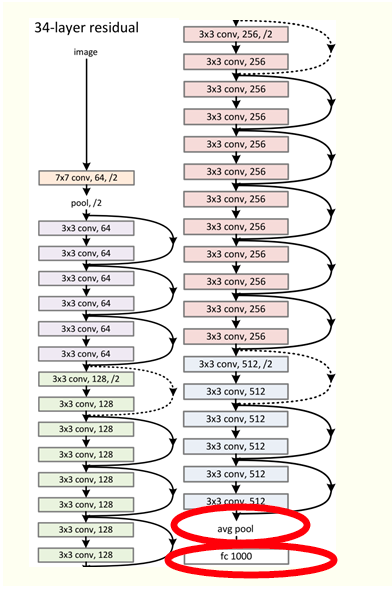

# Identical residual block

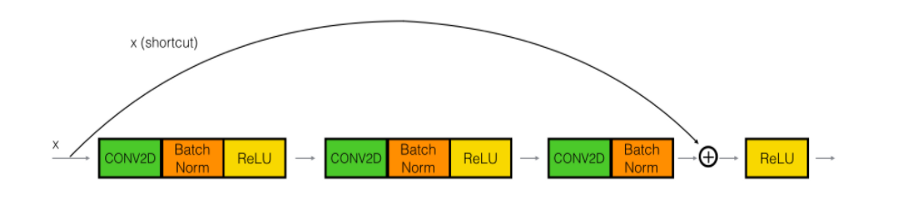

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class IdenticalBlock(tf.keras.Model):
    def __init__(self, filters):
        f1, f2 = filters
        super(IdenticalBlock, self).__init__()
        # layer 1
        self.Conv1 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN1 = tf.keras.layers.BatchNormalization()
        # layer 2
        self.Conv2 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(3, 3), use_bias=False, padding="same"
        )
        self.BN2 = tf.keras.layers.BatchNormalization()
        # layer 3
        self.Conv3 = tf.keras.layers.Conv2D(
            filters=f2, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN3 = tf.keras.layers.BatchNormalization()
    
    def call(self,x):
        x_skip = x
        # layer 1

        Conv1 = self.Conv1(x)
        BN1 = self.BN1(Conv1)
        BN1 = tf.nn.leaky_relu(BN1)

        # layer 2

        Conv2 = self.Conv2(BN1)
        BN2 = self.BN2(Conv2)
        BN2 = tf.nn.leaky_relu(BN2)

        # layer 3

        Conv3 = self.Conv3(BN2)
        BN3 = self.BN3(Conv3)

        # add the output of layer 3 with the input

        add = tf.keras.layers.Add()([BN3, x_skip])

        add = tf.nn.leaky_relu(add)

        return add

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])


identical_block = IdenticalBlock(filters=[64, 3])
identical_block.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   192         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.leaky_relu (TFOpLambda)  (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

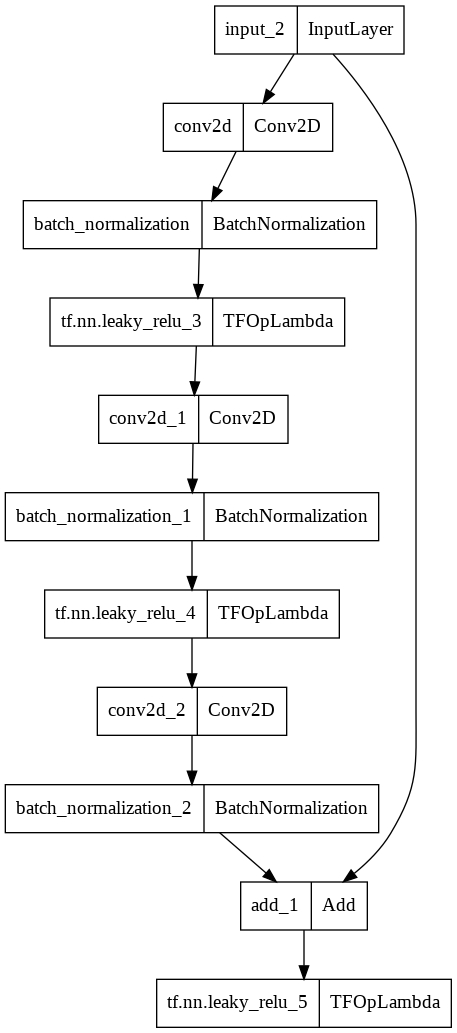

In [3]:
tf.keras.utils.plot_model(identical_block.build_model())

# Convolutional residual block

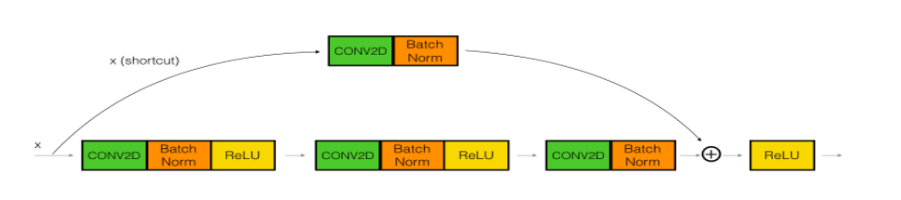

In [4]:
class ConvolutionalBlock(tf.keras.Model):
    def __init__(self, filters,strides=(1, 1)):
        f1, f2 = filters
        super(ConvolutionalBlock, self).__init__()
        # layer 1
        self.Conv1 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(1, 1), strides=strides, use_bias=False, padding="valid"
        )
        self.BN1 = tf.keras.layers.BatchNormalization()
        # layer 2
        self.Conv2 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(3, 3), use_bias=False, padding="same"
        )
        self.BN2 = tf.keras.layers.BatchNormalization()
        # layer 3
        self.Conv3 = tf.keras.layers.Conv2D(
            filters=f2, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN3 = tf.keras.layers.BatchNormalization()

        # layer 4
        self.Conv4 = tf.keras.layers.Conv2D(
            filters=f2, kernel_size=(1, 1), strides=strides, use_bias=False, padding="valid"
        )
        self.BN4 = tf.keras.layers.BatchNormalization()
    
    def call(self,x):
        x_skip = x
        x_skip = self.Conv4(x_skip)
        x_skip = self.BN4(x_skip)
        # layer 1

        Conv1 = self.Conv1(x)
        BN1 = self.BN1(Conv1)
        BN1 = tf.nn.leaky_relu(BN1)

        # layer 2

        Conv2 = self.Conv2(BN1)
        BN2 = self.BN2(Conv2)
        BN2 = tf.nn.leaky_relu(BN2)

        # layer 3

        Conv3 = self.Conv3(BN2)
        BN3 = self.BN3(Conv3)

        # add the output of layer 3 with the input

        add = tf.keras.layers.Add()([BN3, x_skip])

        add = tf.nn.leaky_relu(add)

        return add

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])


conv_block = ConvolutionalBlock(filters=[64, 3])
conv_block.build_model().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 64)   192         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.nn.leaky_relu_6 (TFOpLambda  (None, 32, 32, 64)  0           ['batch_normalization_3[0][

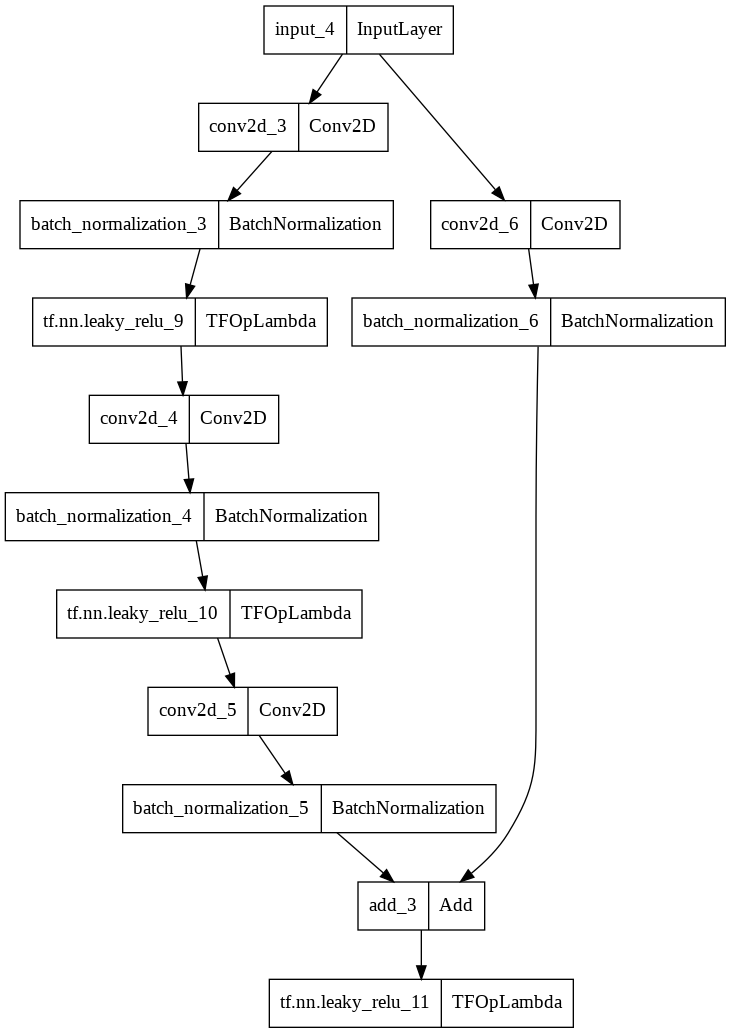

In [5]:
tf.keras.utils.plot_model(conv_block.build_model())

In [6]:
class ResNet(tf.keras.models.Model):
    def __init__(self):
        super(ResNet, self).__init__()

        # block 1
        self.input_conv = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(5, 5),
            strides=(1, 1),
            use_bias=False,
            padding="same",
        )

        self.BN1 = tf.keras.layers.BatchNormalization()
        self.MaxPool = tf.keras.layers.MaxPool2D()
        self.drops = tf.keras.layers.Dropout(0.5)
        # block 2
        self.identical_block_1 = IdenticalBlock(filters=[64, 32])
        # block 3
        self.identical_block_2 = IdenticalBlock(filters=[64, 32])
        # block 4
        self.conv_block_3 = ConvolutionalBlock(filters=[128, 64], strides=(2, 2))
        # block 5
        self.identical_block_4 = IdenticalBlock(filters=[128, 64])
        # block 6
        self.identical_block_5 = IdenticalBlock(filters=[128, 64])
        # block 7
        self.conv_block_6 = ConvolutionalBlock(filters=[256, 128], strides=(2, 2))
        # MPL block

        self.D1 = tf.keras.layers.Dense(units=256, use_bias=False)
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.OUT = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = inputs
        x = self.input_conv(x)
        x = self.BN1(x)
        x = tf.nn.leaky_relu(x)
        x = self.MaxPool(x)
        x = self.identical_block_1(x)
        x = self.identical_block_2(x)
        x = self.conv_block_3(x)
        x = self.identical_block_4(x)
        x = self.identical_block_5(x)
        x = self.conv_block_6(x)
        x = self.drops(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.D1(x)
        x = self.drops(x)
        x = self.BN2(x)
        x = tf.nn.leaky_relu(x)
        output = tf.nn.softmax(self.OUT(x))
        return output

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

In [7]:
model = ResNet()
model.build_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   2400        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.nn.leaky_relu_12 (TFOpLambd  (None, 32, 32, 32)  0           ['batch_normalization_7[0][

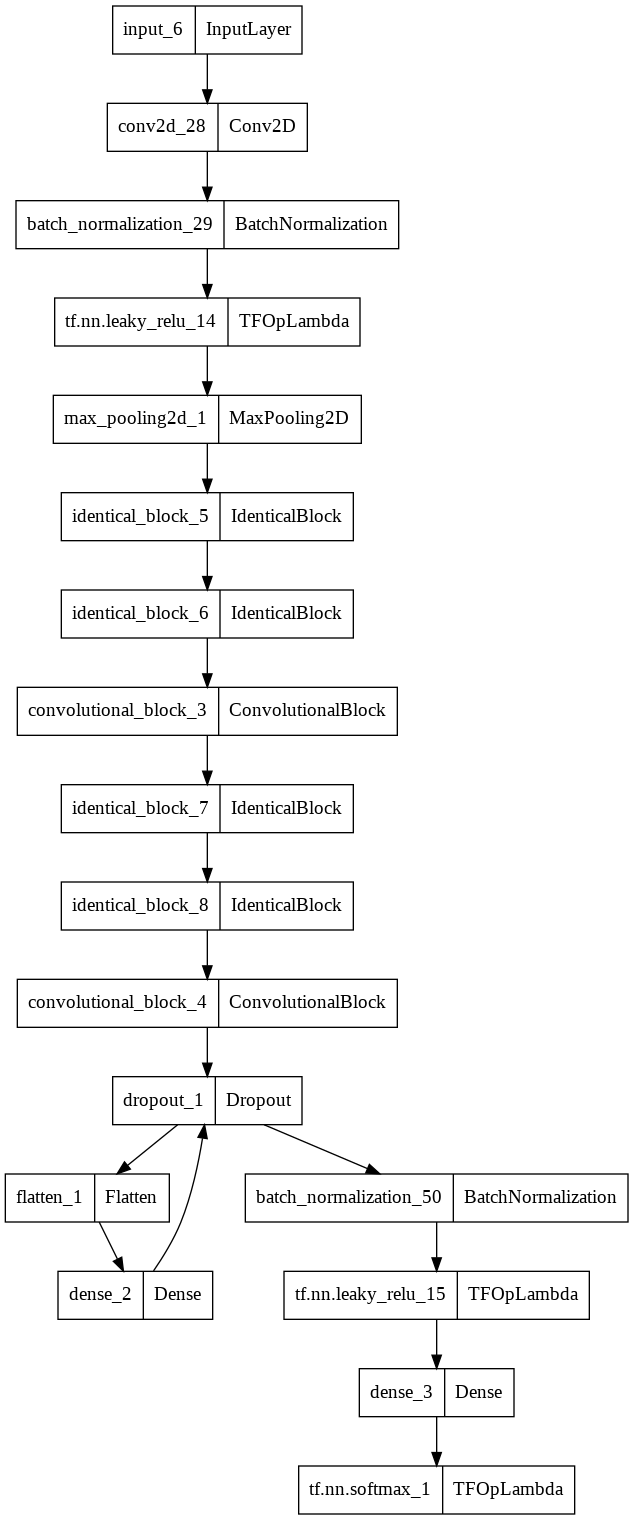

In [8]:
tf.keras.utils.plot_model(ResNet().build_model())

In [9]:
(training_x, training_y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
training_x.shape, training_y.shape, x_test.shape, y_test.shape

170498071/170498071 [==============================] - 14s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

#### split training data into train,valid

In [10]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [11]:
split_size = 30000

x_train = training_x[:split_size]
y_train = training_y[:split_size]

x_val = training_x[split_size:]
y_val = training_y[split_size:]

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_val = y_val.reshape(-1)

x_train.shape, y_train.shape , x_val.shape, y_val.shape ,x_test.shape, y_test.shape 

((30000, 32, 32, 3),
 (30000,),
 (20000, 32, 32, 3),
 (20000,),
 (10000, 32, 32, 3),
 (10000,))

In [12]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)

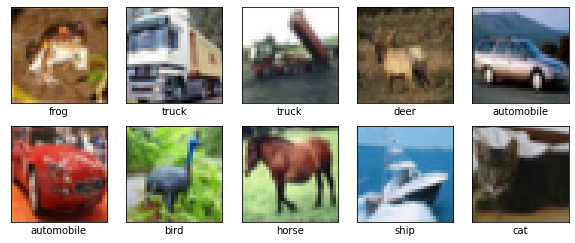

In [13]:
plt.figure(figsize=(10, 4))  # Set the size of the plot

for i in range(10):

    plt.subplot(2,5,i+1)  # Create a subplot on a 5x5 grid for index i

    plt.xticks([])  # Remove the ticks of the number line from the x axis
    plt.yticks([])  # Remove the ticks of the number line from the y axis

    plt.imshow(
        x_train[i]
    )  # Plot the image, no need to use the cmap parameter since this image is in RGB

    target_index = tf.argmax(
        y_train[i]
    )  # Convert the one-hot encoding to the original value
    plt.xlabel(class_names[target_index])

In [14]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5) 
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [15]:
def augment_data_pipeline(x,y,batch_size=32,training=False):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    if (training):
        data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    data = data.shuffle(1024)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [16]:
train_dataset = augment_data_pipeline(x_train,y_train,training=True)
valid_dataset = augment_data_pipeline(x_val,y_val)
test_dataset = augment_data_pipeline(x_test,y_test)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy"],
)

model.fit(train_dataset, epochs=150, validation_data=valid_dataset,verbose=2)

Epoch 1/150
938/938 - 26s - loss: 0.0797 - accuracy: 0.3289 - val_loss: 0.0883 - val_accuracy: 0.3108 - 26s/epoch - 28ms/step
Epoch 2/150
938/938 - 15s - loss: 0.0690 - accuracy: 0.4433 - val_loss: 0.0766 - val_accuracy: 0.3821 - 15s/epoch - 16ms/step
Epoch 3/150
938/938 - 14s - loss: 0.0631 - accuracy: 0.5008 - val_loss: 0.0628 - val_accuracy: 0.5123 - 14s/epoch - 15ms/step
Epoch 4/150
938/938 - 14s - loss: 0.0589 - accuracy: 0.5426 - val_loss: 0.0630 - val_accuracy: 0.5128 - 14s/epoch - 15ms/step
Epoch 5/150
938/938 - 16s - loss: 0.0561 - accuracy: 0.5701 - val_loss: 0.0659 - val_accuracy: 0.4966 - 16s/epoch - 17ms/step
Epoch 6/150
938/938 - 15s - loss: 0.0533 - accuracy: 0.5933 - val_loss: 0.0643 - val_accuracy: 0.5001 - 15s/epoch - 16ms/step
Epoch 7/150
938/938 - 15s - loss: 0.0514 - accuracy: 0.6096 - val_loss: 0.0519 - val_accuracy: 0.6028 - 15s/epoch - 16ms/step
Epoch 8/150
938/938 - 14s - loss: 0.0494 - accuracy: 0.6276 - val_loss: 0.0812 - val_accuracy: 0.4236 - 14s/epoch - 15

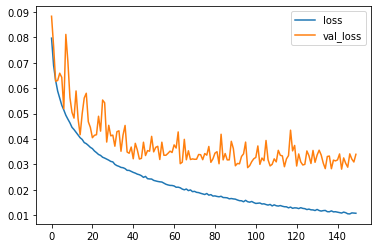

In [18]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot.line()

In [19]:
model.evaluate(test_dataset)

313/313 [==============================] - 2s 5ms/step - loss: 0.0350 - accuracy: 0.7596


[0.03503873571753502, 0.7595999836921692]

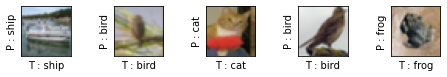

In [37]:
for x,y in test_dataset.take(1):
  pred = model(x, training=False)
  pred = tf.argmax(pred, axis=-1)
  plt.figure(figsize=(8, 2)) 
  for i in range(5):
    plt.subplot(2,5,i+1)  

    plt.xticks([]) 
    plt.yticks([]) 

    plt.imshow(
        x[i]
    )

    plt.xlabel('T : ' + class_names[tf.argmax(y[i])]) # True Value
    plt.ylabel('P : ' +class_names[tf.squeeze(pred[i])])